In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,Time,Stat
0,2-Jan-86,209.59
1,3-Jan-86,210.88
2,6-Jan-86,210.65
3,7-Jan-86,213.80
4,8-Jan-86,207.97


In [4]:
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace = True)

In [5]:
df = pd.read_csv('kagglex_project_data.csv')
df = df.loc[:, ["date", "port_volume"]]
df["Time"] = pd.to_datetime(df["date"])
df.set_index('Time', inplace = True)

In [6]:
df.drop(columns = ["date"], inplace = True)
df.rename(columns = {"port_volume": "Stat"}, inplace = True)

In [7]:
df

,Stat
Time,
2020-01-03,99.075588
2020-01-06,98.924841
2020-01-07,98.281903
2020-01-08,98.654674
2020-01-09,98.717624
...,...
2023-10-02,93.829291
2023-10-03,92.083421
2023-10-04,92.536817


<AxesSubplot:xlabel='Time'>

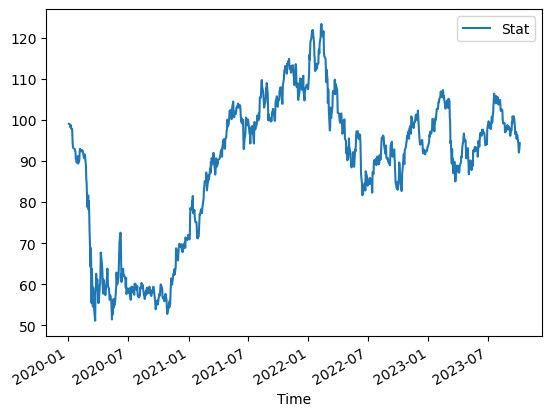

In [8]:
df.plot()

In [9]:
test_percent = 0.4
test_point = np.round(len(df) * test_percent)
test_ind = int(len(df) - test_point)
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [10]:
train

,Stat
Time,
2020-01-03,99.075588
2020-01-06,98.924841
2020-01-07,98.281903
2020-01-08,98.654674
2020-01-09,98.717624
...,...
2022-03-30,105.332022
2022-03-31,101.720353
2022-04-01,101.749114


In [11]:
test

,Stat
Time,
2022-04-06,99.752324
2022-04-07,99.314916
2022-04-08,101.135160
2022-04-11,101.611812
2022-04-12,100.127665
...,...
2023-10-02,93.829291
2023-10-03,92.083421
2023-10-04,92.536817


In [12]:
from sklearn.preprocessing import MinMaxScaler

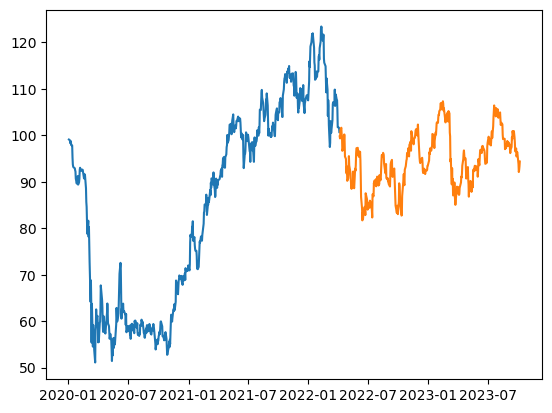

In [13]:
scaler = MinMaxScaler()
scaler.fit(train[['Stat']])
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
plt.plot(train)
plt.plot(test)

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 30
batch_size = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length = length, batch_size = batch_size)
len(scaled_train)

565

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

n_feat = 1

model = Sequential();
model.add(layers.LSTM(100, return_sequences = True, input_shape = (length, n_feat)))
model.add(layers.LSTM(100))
model.add(layers.Dense(1))
model.compile(loss= 'mse', optimizer= 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model.fit(generator, epochs= 2, verbose= 1)

Epoch 1/2
535/535 [==============================] - 15s 22ms/step - loss: 0.0075
Epoch 2/2
535/535 [==============================] - 11s 20ms/step - loss: 0.0025


<AxesSubplot:>

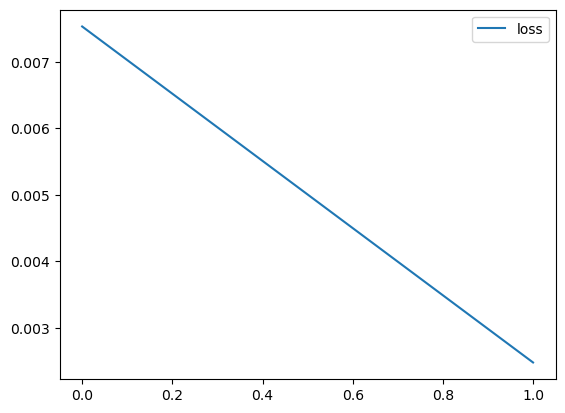

In [17]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [18]:
test_predictions = []

j = len(scaled_test) - length


for i in range(j):
    eval_batch = scaled_test[i:i+length]
    shifted_batch = eval_batch.reshape((1, length, n_feat))
    this_pred = model.predict(shifted_batch)
    this_pred = this_pred[0]
    test_predictions.append(this_pred)
    eval_batch = eval_batch[1:];
    b = np.array([this_pred])

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 48ms/step


In [19]:
test_predictions

[array([0.5012599], dtype=float32),
 array([0.50046945], dtype=float32),
 array([0.4972317], dtype=float32),
 array([0.50636256], dtype=float32),
 array([0.5183325], dtype=float32),
 array([0.53341794], dtype=float32),
 array([0.5547059], dtype=float32),
 array([0.57758844], dtype=float32),
 array([0.596351], dtype=float32),
 array([0.6035661], dtype=float32),
 array([0.60579866], dtype=float32),
 array([0.6001168], dtype=float32),
 array([0.59264046], dtype=float32),
 array([0.58748555], dtype=float32),
 array([0.57872397], dtype=float32),
 array([0.5596612], dtype=float32),
 array([0.5255753], dtype=float32),
 array([0.48419595], dtype=float32),
 array([0.44069237], dtype=float32),
 array([0.410688], dtype=float32),
 array([0.3905787], dtype=float32),
 array([0.38316602], dtype=float32),
 array([0.38934574], dtype=float32),
 array([0.40038258], dtype=float32),
 array([0.4091014], dtype=float32),
 array([0.42919227], dtype=float32),
 array([0.44816816], dtype=float32),
 array([0.46206

376
346


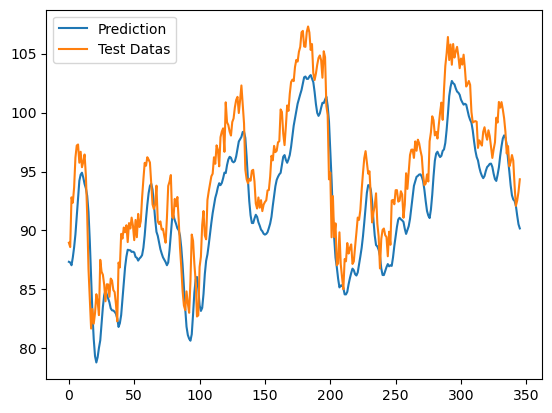

In [20]:
orig_predictions = scaler.inverse_transform(test_predictions)
eval_batch = scaler.inverse_transform(scaled_test);

err_predictions_ok = []
err_predictions_nok = []
err_thresh = []
j = len(orig_predictions)
print(len(eval_batch))
print(len(orig_predictions))

for i in range(j):
    e = abs(eval_batch[length + i] - orig_predictions[i])
    th = 400; err_thresh.append(th);
    
    if (e[0] > th): 
        err_predictions_nok.append(e[0]); err_predictions_ok.append(0);  
    else:
        err_predictions_nok.append(0); err_predictions_ok.append(e[0]);


                                     
                                     
plt.plot(orig_predictions, label = "Prediction")
plt.plot(eval_batch[length:], label = "Test Datas")                                     
# plt.plot(err_predictions_ok, label = "ERROR OK")   
# plt.plot(err_predictions_nok, label = "ERROR-NOT-OK")
# plt.plot(err_thresh, label = "ERROR-THRESHOLD")                                                         
plt.legend()                           
plt.show()